In [17]:
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [18]:
X_train = joblib.load("Data/Xtrain1.pkl")
Y_train = np.load('Data/Ytrain1.npy')
print(X_train.shape)
print(Y_train.shape)

patient_ids = X_train["Patient_Id"].values
X_train = np.vstack(X_train["Skeleton_Features"].values)

(700, 2)
(700,)


In [ ]:
def add_angle_feature(X):
    c12x, c12y = 2*(12-1), 2*(12)-1  # 22, 23
    c14x, c14y = 2*(14-1), 2*(14)-1  # 26, 27
    c16x, c16y = 2*(16-1), 2*(16)-1  # 30, 31

    a = np.stack([X[:, c12x], X[:, c12y]], axis=1)
    b = np.stack([X[:, c14x], X[:, c14y]], axis=1)
    c = np.stack([X[:, c16x], X[:, c16y]], axis=1)

    ba = a - b
    bc = c - b
    dot = (ba * bc).sum(axis=1)
    cross = ba[:, 0] * bc[:, 1] - ba[:, 1] * bc[:, 0]
    angles_deg = np.degrees(np.arctan2(np.abs(cross), dot)).reshape(-1, 1)

    # Append angle as last column
    return np.hstack([X, angles_deg])

X_with_angle = add_angle_feature(X_train)


X_tr, X_te, y_tr, y_te = train_test_split(
    X_with_angle, Y_train, test_size=0.4, random_state=42, stratify=Y_train
)

# Feature selection via RFECV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
base = ExtraTreesClassifier(
    n_estimators=600, max_depth=None, min_samples_leaf=1, n_jobs=-1, random_state=42
)

selector = RFECV(
    estimator=base,
    step=0.1,             # drop 10% per iteration
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1
)
selector.fit(X_tr, y_tr)

mask = selector.support_
X_tr_sel = X_tr[:, mask]
X_te_sel = X_te[:, mask]

# Train final classifier
final_clf = ExtraTreesClassifier(
    n_estimators=1000, max_depth=None, min_samples_leaf=1, n_jobs=-1, random_state=42
)
final_clf.fit(X_tr_sel, y_tr)

# Evaluate
y_pred = final_clf.predict(X_te_sel)
train_pred = final_clf.predict(X_tr_sel)

print("Selected features:", mask.sum(), "/", X_tr.shape[1])
print(f"Train macro-F1: {f1_score(y_tr, train_pred, average='macro'):.4f}")
print(f"Test  macro-F1: {f1_score(y_te, y_pred, average='macro'):.4f}")


Selected features: 133 / 133
Train macro-F1: 1.0000
Test  macro-F1: 1.0000


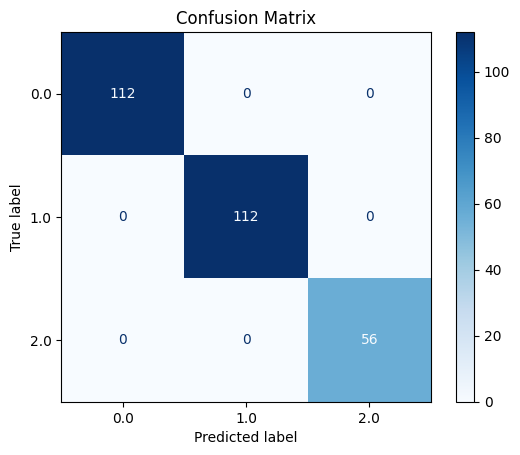

In [20]:
classes = np.unique(y_te)
cm = confusion_matrix(y_te, y_pred, labels=classes)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()